# Designing a Scheduler

# Appendix A

# Testing the Code

In [1]:

# Define a custom class that wraps the task object and stores its utility value
class TaskWrapper(object):
    def __init__(self, task, utility):
        self.task = task
        self.utility = utility
    
    # Implement the __lt__ method to compare the utility values
    def __lt__(self, other):
        return self.utility < other.utility

class MaxHeapq:
    def __init__(self):    
        """
        Parameters
        ----------
        None
        """    
        self.heap = [] 
        
    def left(self, i):
        # Return the index of the left child node
        return 2 * i + 1

    def right(self, i):
        # Return the index of the right child node
        return 2 * i + 2
    
    def parent(self, i):
        # Return the index of the parent node
        return (i - 1)//2

    def maxk(self):     
        # Return the task object with the maximum utility value in the heap 
        return self.heap[0].task
  
    def heappush(self, task): 
        task_wrapper = TaskWrapper(task, task.utility)
        self.heap.append(task_wrapper)
        i = len(self.heap) - 1 
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i) # The index of the parent of i
            # Swap the parent and the child
            self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
            i = j # Update i to be the index of the parent
    
    def increase_key(self, i, key): 
        if key.utility < self.heap[i].utility:
            raise ValueError('new key is smaller than the current key')
        self.heap[i] = key 
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i) 
            self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
            i = j 

    def heapify(self, i): 
        l = self.left(i) # The index of the left child of i
        r = self.right(i) # The index of the right child of i
        if l < len(self.heap) and self.heap[l] > self.heap[i]:
            largest = l # The index of the largest element among i and its children
        else:
            largest = i 
        if r < len(self.heap) and self.heap[r] > self.heap[largest]:
            largest = r 
        if largest != i:
            self.heap[i], self.heap[largest] = self.heap[largest], self.heap[i]
            self.heapify(largest)

    def heappop(self):
       # Pop and return the task object with the maximum utility value from the heap 
        if len(self.heap) < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.maxk()
        self.heap[0] = self.heap[-1] 
        self.heap.pop() 
        self.heapify(0) 
        return maxk
    
    def __len__(self):
       # Return the number of elements in the heap 
       return len(self.heap)

# Define a class that represents a task object 
class Task:
    NOT_STARTED = 'N'
    IN_PRIORITY_QUEUE = 'I'
    COMPLETED = 'C'
    
    def __init__(self, id, description, duration,
                 dependencies, status=NOT_STARTED, start_time = 9*60,\
                 flexibility = True, utility = 0):
        self.id = id
        self.description = description
        self.duration = duration
        self.dependencies = dependencies
        self.status = status
        self.start_time = start_time
        self.flexibility = flexibility
        self.utility = utility
        
    def __lt__(self, other):
        # Compare the tasks based on their utility values
        return self.utility < other.utility

# Define a class that inherits from the MaxHeapq class and uses a heap 
#to store and schedule tasks 
class TaskScheduler(MaxHeapq):
    def __init__(self, tasks):
        # Initialize the superclass with an empty heap 
        super().__init__()
        # Store the tasks in a dictionary for easy access by id 
        self.tasks = {task.id: task for task in tasks}
        
    def print_self(self):
        # Print the tasks added to the scheduler 
        print("Tasks added to the simple scheduler:")
        print("--------------------------------------")
        for t in self.tasks.values():
            print(f"➡️'{t.description}', duration = {t.duration} mins.")   
            if len(t.dependencies)>0:
                print(f"\t ⚠️ This task depends on others!")  
            
    def remove_dependency(self, id):
        # Remove the dependency of a completed task from other tasks 
        for t in self.tasks.values():
            if t.id != id and id in t.dependencies:
                t.dependencies.remove(id) 
    
    def count_dependents(self, task): #O(n) --> for loop
        """
        Returns the number of tasks dependent on the current task.
        """
        dependents = 0
        #print(self.tasks)
        for task_id in self.tasks:
            t = self.tasks[task_id]
            
            # Check if the current task is in the dependencies list of another task
            
            if task.id in t.dependencies:
                dependents += 1
        return dependents
    
    def priority_value(self, task, current_time):
        """
        Returns the priority value of the task based on the utility function
        """
        utility =  0.3*self.count_dependents(task)

        utility += (not(task.flexibility))* (10 if (abs(current_time -task.start_time)) == 0 else 0)
        

        utility += (not(task.flexibility))* \
        (10 if (abs(current_time -task.start_time)) < (self.tasks[0]).duration else 0)
       

        return utility

    
        
            
    def get_tasks_ready(self, current_time):
        # Use a set to store the ids of the ready tasks 
        ready_tasks = set()
        for task in self.tasks.values():
            # Calculate the priority value for each task 
            #using a formula that involves flexibility, 
            #start_time, and dependencies
            task.utility = self.priority_value(task, current_time)
            # Need to change here from number of dependencies to 
            #how many tasks are dependent on this, 
            #and need to account for tasks that are not starting now but 
            #before the other task finsihes.
            # Check if the task has no dependencies and is not yet in the queue 
            if task.status == Task.NOT_STARTED and not task.dependencies:
                # Update the status of the task 
                task.status = Task.IN_PRIORITY_QUEUE
                # Add the id of the task to the set of ready tasks 
                ready_tasks.add(task.id)
        
        # Push the ready tasks into the priority queue 
        for id in ready_tasks:
            self.heappush(self.tasks[id])
    
    def check_unscheduled_tasks(self):
        # Check if there are any tasks that are not started or completed 
        for task in self.tasks.values():
            if task.status == Task.NOT_STARTED:
                return True
        return False  
    
    def format_time(self, time):
        # Format the time in minutes into hours and minutes 
        hours, minutes = divmod(time, 60)
        return f"{hours}h{minutes:02d}"
    
    def run_task_scheduler(self, starting_time):
        # Run the scheduler and execute the tasks in order of priority 
        current_time = starting_time
        print("Running a simple scheduler:\n")
        while self.check_unscheduled_tasks() or self.heap:
            # Identify tasks that are ready to execute and push them into the priority queue 
            self.get_tasks_ready(current_time)
            # Check for tasks in the priority queue 
            if len(self.heap) > 0 :
                # Get the task on top of the priority queue 
                task = self.heappop()
                print(f"🕰t={self.format_time(current_time)}")
                print(f"\tstarted '{task.description}' for {task.duration} mins... with utility {task.utility}")
                current_time += task.duration            
                print(f"\t✅ t={self.format_time(current_time)}, task completed!") 
                # If the task is done, remove it from the dependency list of other tasks 
                self.remove_dependency(task.id)
                # Update the status of the task 
                task.status = Task.COMPLETED
       
        total_time = current_time - starting_time             
        print(f"\n🏁 Completed all planned tasks in {self.format_time(total_time)}!")


Running a simple scheduler:

🕰t=0h00
	started 'Task 0' for 68 mins... with utility 2.1
	✅ t=1h08, task completed!
🕰t=1h08
	started 'Task 1' for 39 mins... with utility 1.2
	✅ t=1h47, task completed!
🕰t=1h47
	started 'Task 2' for 60 mins... with utility 1.5
	✅ t=2h47, task completed!
🕰t=2h47
	started 'Task 3' for 44 mins... with utility 1.2
	✅ t=3h31, task completed!
🕰t=3h31
	started 'Task 4' for 78 mins... with utility 0.6
	✅ t=4h49, task completed!
🕰t=4h49
	started 'Task 6' for 50 mins... with utility 0.3
	✅ t=5h39, task completed!
🕰t=5h39
	started 'Task 5' for 81 mins... with utility 0.3
	✅ t=7h00, task completed!
🕰t=7h00
	started 'Task 7' for 64 mins... with utility 0.0
	✅ t=8h04, task completed!
🕰t=8h04
	started 'Task 8' for 14 mins... with utility 0.0
	✅ t=8h18, task completed!
🕰t=8h18
	started 'Task 9' for 65 mins... with utility 0.0
	✅ t=9h23, task completed!

🏁 Completed all planned tasks in 9h23!
Running a simple scheduler:

🕰t=0h00
	started 'Task 0' for 47 mins... with utilit

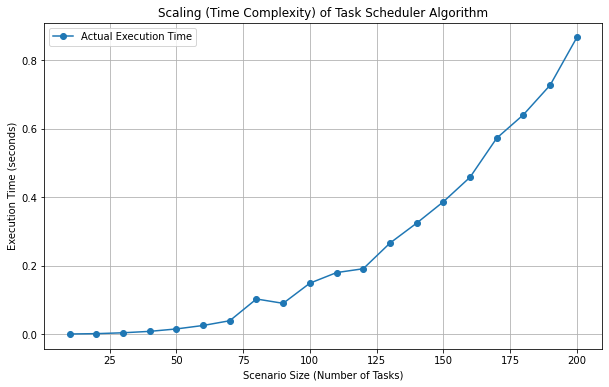

In [2]:
#Experimental time complexity

import timeit
import time
import matplotlib.pyplot as plt
import random
import numpy as np

# Function to generate a random input scenario with 'n' tasks
def generate_random_input_scenario(n):
    tasks = []
    for i in range(n):
        duration = random.randint(10, 100)  # Random duration between 10 and 100 minutes
        dependencies = random.sample(range(i), min(i, 3))  # Random dependencies on previous tasks
        tasks.append(Task(id=i, description=f"Task {i}", duration=duration, dependencies=dependencies))
    return tasks

# Generate a list of scenario sizes between 10 and 2000 with a step size of 100
scenario_sizes = list(range(10, 201, 10))
execution_times = []

for size in scenario_sizes:
    input_scenario = generate_random_input_scenario(size)
    
    execution_time = timeit.timeit(lambda: TaskScheduler(input_scenario).run_task_scheduler(starting_time=0), 
                                   number=1)
    execution_times.append(execution_time)

n_squared = [i^2 for i in scenario_sizes]
n_values = np.linspace(1, 100, 400)
y_values = n_values ** 2 * np.log(n_values)

plt.figure(figsize=(10, 6))
#plt.plot(n_values, y_values, label='O(n^2 logn)')

# Plot the actual execution times
plt.plot(scenario_sizes, execution_times, marker='o', label='Actual Execution Time')
#plt.plot(scenario_sizes, n_squared, color = 'r')

plt.xlabel('Scenario Size (Number of Tasks)')
plt.ylabel('Execution Time (seconds)')
plt.title('Scaling (Time Complexity) of Task Scheduler Algorithm')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
#non designed input

import pandas as pd

tasks = [
    Task(0, 'Wake up at 10:00 AM', 10, [], start_time = 10*60,\
         flexibility = False),
    Task(1, 'get dressed and ready', 20, [0, 2]),
    Task(2, 'eat a healthy breakfast', 30, [0]),
    Task(3, 'Charge T-money Card', 10, [1]),
    Task(4, 'Go to a cafe', 20, [3]),
    Task(5, 'Contact applicants', 80, [6, 4]),
    Task(6, 'Collect applicants contact', 40, [4]),
    Task(7, 'Do PCW', 100 , [4]),
    Task(8, 'Attend CS110 session', 90 , [7], start_time = 16*60,\
         flexibility = False),
    Task(9, 'Go back to the Res', 20 , [8, 4, 11, 12]),
    Task(10, 'Read the polymer chemistry research paper', 30 , []),
    Task(11, 'Go to a korean grocery store and buy Ramen', 60, [13]),
    Task(12, 'Create a presentation for research key findings', 120, [10]),
    Task(13, 'Create a grocery list' , 15, [])
      
]



# Create a Pandas DataFrame from the tasks
data = {
    'Task ID': [task.id for task in tasks],
    'Description': [task.description for task in tasks],
    'Duration (mins)': [task.duration for task in tasks],
    'Dependencies': [task.dependencies for task in tasks],
    'Start Time (mins)': [task.start_time for task in tasks],
    'Flexibility': [task.flexibility for task in tasks]
}

df = pd.DataFrame(data)

# Print the DataFrame
df

,Task ID,Description,Duration (mins),Dependencies,Start Time (mins),Flexibility
0,0,Wake up at 10:00 AM,10,[],600,False
1,1,get dressed and ready,20,"[0, 2]",540,True
2,2,eat a healthy breakfast,30,[0],540,True
3,3,Charge T-money Card,10,[1],540,True
4,4,Go to a cafe,20,[3],540,True
5,5,Contact applicants,80,"[6, 4]",540,True
6,6,Collect applicants contact,40,[4],540,True
7,7,Do PCW,100,[4],540,True
8,8,Attend CS110 session,90,[7],960,False
9,9,Go back to the Res,20,"[8, 4, 11, 12]",540,True


In [4]:

task_scheduler = TaskScheduler(tasks)
task_scheduler.print_self()
task_scheduler.run_task_scheduler(10*60)

Tasks added to the simple scheduler:
--------------------------------------
➡️'Wake up at 10:00 AM', duration = 10 mins.
➡️'get dressed and ready', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'eat a healthy breakfast', duration = 30 mins.
	 ⚠️ This task depends on others!
➡️'Charge T-money Card', duration = 10 mins.
	 ⚠️ This task depends on others!
➡️'Go to a cafe', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Contact applicants', duration = 80 mins.
	 ⚠️ This task depends on others!
➡️'Collect applicants contact', duration = 40 mins.
	 ⚠️ This task depends on others!
➡️'Do PCW', duration = 100 mins.
	 ⚠️ This task depends on others!
➡️'Attend CS110 session', duration = 90 mins.
	 ⚠️ This task depends on others!
➡️'Go back to the Res', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Read the polymer chemistry research paper', duration = 30 mins.
➡️'Go to a korean grocery store and buy Ramen', duration = 60 mins.
	 ⚠️ This task depends on others!
➡️'Cre

In [5]:
# Better designed input

tasks = [
    Task(0, 'Wake up at 10:00 AM', 10, [], start_time = 10*60,\
         flexibility = False),
    Task(1, 'get dressed and ready', 20, [0, 2]),
    Task(2, 'eat a healthy breakfast', 30, [0]),
    Task(3, 'Charge T-money Card', 10, [2, 1]),
    Task(4, 'Go to a cafe', 20, [3, 1]),
    Task(5, 'Contact applicants', 80, [6, 4]),
    Task(6, 'Collect applicants contact', 40, [4]),
    Task(7, 'Do PCW', 100 , [4]),
    Task(8, 'Attend CS110 session', 90 , [7, 4], start_time = 16*60,\
         flexibility = False),
    Task(9, 'Go back to the Res', 20 , [8, 4, 11, 12]),
    Task(10, 'Read the polymer chemistry research paper', 30 , [4]),
    Task(11, 'Go to a korean grocery store and buy Ramen', 60, [13, 4]),
    Task(12, 'Create a presentation for research key findings', 120, [4, 10]),
    Task(13, 'Create a grocery list' , 15, [4])
      
]


# Create a Pandas DataFrame from the tasks
data = {
    'Task ID': [task.id for task in tasks],
    'Description': [task.description for task in tasks],
    'Duration (mins)': [task.duration for task in tasks],
    'Dependencies': [task.dependencies for task in tasks],
    'Start Time (mins)': [task.start_time for task in tasks],
    'Flexibility': [task.flexibility for task in tasks]
}

df = pd.DataFrame(data)

# Print the DataFrame
df

,Task ID,Description,Duration (mins),Dependencies,Start Time (mins),Flexibility
0,0,Wake up at 10:00 AM,10,[],600,False
1,1,get dressed and ready,20,"[0, 2]",540,True
2,2,eat a healthy breakfast,30,[0],540,True
3,3,Charge T-money Card,10,"[2, 1]",540,True
4,4,Go to a cafe,20,"[3, 1]",540,True
5,5,Contact applicants,80,"[6, 4]",540,True
6,6,Collect applicants contact,40,[4],540,True
7,7,Do PCW,100,[4],540,True
8,8,Attend CS110 session,90,"[7, 4]",960,False
9,9,Go back to the Res,20,"[8, 4, 11, 12]",540,True


In [6]:

task_scheduler = TaskScheduler(tasks)
task_scheduler.print_self()
task_scheduler.run_task_scheduler(10*60)


Tasks added to the simple scheduler:
--------------------------------------
➡️'Wake up at 10:00 AM', duration = 10 mins.
➡️'get dressed and ready', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'eat a healthy breakfast', duration = 30 mins.
	 ⚠️ This task depends on others!
➡️'Charge T-money Card', duration = 10 mins.
	 ⚠️ This task depends on others!
➡️'Go to a cafe', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Contact applicants', duration = 80 mins.
	 ⚠️ This task depends on others!
➡️'Collect applicants contact', duration = 40 mins.
	 ⚠️ This task depends on others!
➡️'Do PCW', duration = 100 mins.
	 ⚠️ This task depends on others!
➡️'Attend CS110 session', duration = 90 mins.
	 ⚠️ This task depends on others!
➡️'Go back to the Res', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Read the polymer chemistry research paper', duration = 30 mins.
	 ⚠️ This task depends on others!
➡️'Go to a korean grocery store and buy Ramen', duration = 60 mins.
	 ⚠️ T

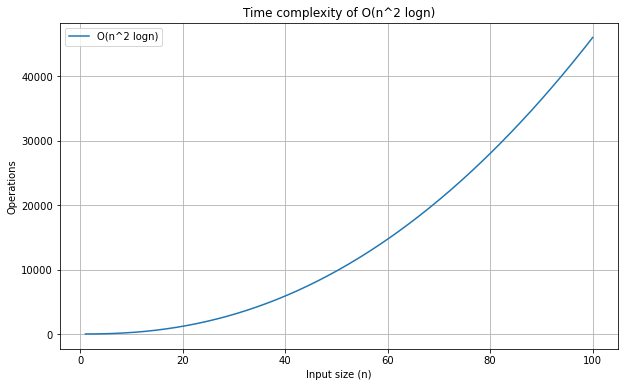

In [7]:
# Python
import matplotlib.pyplot as plt
import numpy as np

n_values = np.linspace(1, 100, 400)
y_values = n_values ** 2 * np.log(n_values)

plt.figure(figsize=(10, 6))
plt.plot(n_values, y_values, label='O(n^2 logn)')
plt.xlabel('Input size (n)')
plt.ylabel('Operations')
plt.title('Time complexity of O(n^2 logn)')
plt.legend()
plt.grid(True)
plt.show()

# Debug for the utility calculation

In [8]:

# Define a custom class that wraps the task object and stores its utility value
class TaskWrapper(object):
    def __init__(self, task, utility):
        self.task = task
        self.utility = utility
    
    # Implement the __lt__ method to compare the utility values
    def __lt__(self, other):
        return self.utility < other.utility

class MaxHeapq:
    def __init__(self):    
        """
        Parameters
        ----------
        None
        """    
        self.heap = [] 
        
    def left(self, i):
        # Return the index of the left child node
        return 2 * i + 1

    def right(self, i):
        # Return the index of the right child node
        return 2 * i + 2
    
    def parent(self, i):
        # Return the index of the parent node
        return (i - 1)//2

    def maxk(self):     
        # Return the task object with the maximum utility value in the heap 
        return self.heap[0].task
  
    def heappush(self, task): 
        task_wrapper = TaskWrapper(task, task.utility)
        self.heap.append(task_wrapper)
        i = len(self.heap) - 1 
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i) # The index of the parent of i
            # Swap the parent and the child
            self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
            i = j # Update i to be the index of the parent
    
    def increase_key(self, i, key): 
        if key.utility < self.heap[i].utility:
            raise ValueError('new key is smaller than the current key')
        self.heap[i] = key 
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i) 
            self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
            i = j 

    def heapify(self, i): 
        l = self.left(i) # The index of the left child of i
        r = self.right(i) # The index of the right child of i
        if l < len(self.heap) and self.heap[l] > self.heap[i]:
            largest = l # The index of the largest element among i and its children
        else:
            largest = i 
        if r < len(self.heap) and self.heap[r] > self.heap[largest]:
            largest = r 
        if largest != i:
            self.heap[i], self.heap[largest] = self.heap[largest], self.heap[i]
            self.heapify(largest)

    def heappop(self):
       # Pop and return the task object with the maximum utility value from the heap 
        if len(self.heap) < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.maxk()
        self.heap[0] = self.heap[-1] 
        self.heap.pop() 
        self.heapify(0) 
        return maxk
    
    def __len__(self):
       # Return the number of elements in the heap 
       return len(self.heap)

# Define a class that represents a task object 
class Task:
    NOT_STARTED = 'N'
    IN_PRIORITY_QUEUE = 'I'
    COMPLETED = 'C'
    
    def __init__(self, id, description, duration,
                 dependencies, status=NOT_STARTED, start_time = 9*60,\
                 flexibility = True, utility = 0):
        self.id = id
        self.description = description
        self.duration = duration
        self.dependencies = dependencies
        self.status = status
        self.start_time = start_time
        self.flexibility = flexibility
        self.utility = utility
        
    def __lt__(self, other):
        # Compare the tasks based on their utility values
        return self.utility < other.utility

# Define a class that inherits from the MaxHeapq class and uses a heap 
#to store and schedule tasks 
class TaskScheduler(MaxHeapq):
    def __init__(self, tasks):
        # Initialize the superclass with an empty heap 
        super().__init__()
        # Store the tasks in a dictionary for easy access by id 
        self.tasks = {task.id: task for task in tasks}
        
    def print_self(self):
        # Print the tasks added to the scheduler 
        print("Tasks added to the simple scheduler:")
        print("--------------------------------------")
        for t in self.tasks.values():
            print(f"➡️'{t.description}', duration = {t.duration} mins.")   
            if len(t.dependencies)>0:
                print(f"\t ⚠️ This task depends on others!")  
            
    def remove_dependency(self, id):
        # Remove the dependency of a completed task from other tasks 
        for t in self.tasks.values():
            if t.id != id and id in t.dependencies:
                t.dependencies.remove(id) 
    
    def count_dependents(self, task): #O(n) --> for loop
        """
        Returns the number of tasks dependent on the current task.
        """
        dependents = 0
        #print(self.tasks)
        for task_id in self.tasks:
            t = self.tasks[task_id]
            
            # Check if the current task is in the dependencies list of another task
            
            if task.id in t.dependencies:
                dependents += 1
        return dependents
    
    def priority_value(self, task, current_time):
        """
        Returns the priority value of the task based on the utility function
        """
        utility =  0.3*self.count_dependents(task)
        print(f"Utility after counting dependents: {utility}")  # Debug print

        condition1 = (not(task.flexibility))* \
        (10 if (abs(current_time -task.start_time)) == 0 else 0)
        print(f"Condition 1: {condition1}")  # Debug print
        utility += condition1

        condition2 = (not(task.flexibility))* \
        (10 if (abs(current_time -task.start_time)) < (self.tasks[0]).duration\
         else 0)
        print(f"Condition 2: {condition2}")  # Debug print
        utility += condition2

        return utility

    
        
            
    def get_tasks_ready(self, current_time):
        # Identify tasks that are ready to execute and push them into the priority queue 
        # Use a set to store the ids of the ready tasks 
        ready_tasks = set()
        for task in self.tasks.values():
            # Calculate the priority value for each task using a formula that 
            #involves flexibility, 
            #start_time, and dependencies
            task.utility = self.priority_value(task, current_time)
            # Need to change here from number of dependencies to how many 
            #tasks are dependent on this, 
            #and need to account for tasks that are not starting now but 
            #before the other task finsihes.
            # Check if the task has no dependencies and is not yet in the queue 
            if task.status == Task.NOT_STARTED and not task.dependencies:
                # Update the status of the task 
                task.status = Task.IN_PRIORITY_QUEUE
                # Add the id of the task to the set of ready tasks 
                ready_tasks.add(task.id)
        
        # Push the ready tasks into the priority queue 
        for id in ready_tasks:
            self.heappush(self.tasks[id])
    
    def check_unscheduled_tasks(self):
        # Check if there are any tasks that are not started or completed 
        for task in self.tasks.values():
            if task.status == Task.NOT_STARTED:
                return True
        return False  
    
    def format_time(self, time):
        # Format the time in minutes into hours and minutes 
        hours, minutes = divmod(time, 60)
        return f"{hours}h{minutes:02d}"
    
    def run_task_scheduler(self, starting_time):
        # Run the scheduler and execute the tasks in order of priority 
        current_time = starting_time
        print("Running a simple scheduler:\n")
        while self.check_unscheduled_tasks() or self.heap:
            # Identify tasks that are ready to execute and push them into the priority queue 
            self.get_tasks_ready(current_time)
            # Check for tasks in the priority queue 
            if len(self.heap) > 0 :
                # Get the task on top of the priority queue 
                task = self.heappop()
                print(f"🕰t={self.format_time(current_time)}")
                print(f"\tstarted '{task.description}' for {task.duration} mins...\
                      with utility {task.utility}")
                current_time += task.duration            
                print(f"\t✅ t={self.format_time(current_time)}, task completed!") 
                # If the task is done, remove it from the dependency list of other tasks 
                self.remove_dependency(task.id)
                # Update the status of the task 
                task.status = Task.COMPLETED
       
        total_time = current_time - starting_time             
        print(f"\n🏁 Completed all planned tasks in {self.format_time(total_time)}!")


In [9]:
 
#if not flexibile then add the start time as well

# Create the list of tasks
tasks = [
    Task(0, 'Wake up at 10:00 AM', 10, [], start_time = 10*60,\
         flexibility = False),
    Task(1, 'get dressed and ready', 20, [0, 2]),
    Task(2, 'eat a healthy breakfast', 30, [0]),
    Task(3, 'Charge T-money Card', 10, [2, 1]),
    Task(4, 'Go to a cafe', 20, [3, 1]),
    Task(5, 'Contact applicants', 80, [6, 4]),
    Task(6, 'Collect applicants contact', 40, [4]),
    Task(7, 'Do PCW', 100 , [4]),
    Task(8, 'Attend CS110 session', 90 , [7, 4], start_time = 16*60, \
         flexibility = False),
    Task(9, 'Go back to the Res', 20 , [8, 4, 11, 12]),
    Task(10, 'Read the polymer chemistry research paper', 30 , [4]),
    Task(11, 'Go to a korean grocery store and buy Ramen', 60, [13, 4]),
    Task(12, 'Create a presentation for research key findings', 120, [4, 10]),
    Task(13, 'Create a grocery list' , 15, [4])
      
]


task_scheduler = TaskScheduler(tasks)
task_scheduler.print_self()
task_scheduler.run_task_scheduler(10*60)


Tasks added to the simple scheduler:
--------------------------------------
➡️'Wake up at 10:00 AM', duration = 10 mins.
➡️'get dressed and ready', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'eat a healthy breakfast', duration = 30 mins.
	 ⚠️ This task depends on others!
➡️'Charge T-money Card', duration = 10 mins.
	 ⚠️ This task depends on others!
➡️'Go to a cafe', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Contact applicants', duration = 80 mins.
	 ⚠️ This task depends on others!
➡️'Collect applicants contact', duration = 40 mins.
	 ⚠️ This task depends on others!
➡️'Do PCW', duration = 100 mins.
	 ⚠️ This task depends on others!
➡️'Attend CS110 session', duration = 90 mins.
	 ⚠️ This task depends on others!
➡️'Go back to the Res', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Read the polymer chemistry research paper', duration = 30 mins.
	 ⚠️ This task depends on others!
➡️'Go to a korean grocery store and buy Ramen', duration = 60 mins.
	 ⚠️ T

# Appendix B

# Improved version of the scheduler

In [10]:
class TaskWrapper(object):
    """
    A wrapper for the Task object that also stores its utility value.

    Attributes
    ----------
        task: 
            The Task object.
        utility: 
            The utility value of the task.
    """

    def __init__(self, task, utility, duration, flexibility, start_time):
        """
        Initializes a new instance of the TaskWrapper class.

        Parameters
        ----------
            task: 
                The Task object.
            utility: 
                The utility value of the task.
            duration:
                The duration of the task in minutes
            flexibility:
                A bool value 
            start_time:
                None or numerical value in minutes 
        """
        
        self.task = task 
        self.utility = utility  
        self.duration = duration
        self.flexibility = flexibility
        self.start_time = start_time

    def __lt__(self, other):
        """
        Compares this TaskWrapper with another TaskWrapper based on 
        their utility values.

        Parameters
        ----------
            other: The other TaskWrapper to compare with.

        Returns
        --------
            True if this TaskWrapper's utility value is less than
            the other TaskWrapper's utility value, False otherwise.
        """
        
        return self.utility < other.utility  # Compare utility values

In [11]:
class MaxHeapq:
    """
    A class that implements a max heap data structure.

    Attributes
    ----------
        heap: 
            An array that represents the heap.
    """

    def __init__(self):
        """
        Initializes a new instance of the MaxHeapq class.
        """
        
        self.heap = [] # A list that represents the heap

    def left(self, i):
        """
        Returns the index of the left child node of a given node.

        parameters
        ----------
            i: The index of the node.

        Returns
        -------
            The index of the left child node.
        """
        
        return 2 * i + 1

    def right(self, i):
        """
        Returns the index of the right child node of a given node.

        parameters
        ----------
            i: The index of the node.

        Returns
        -------
            The index of the right child node.
        """
        
        return 2 * i + 2

    def parent(self, i):
        """
        Returns the index of the parent node of a given node.

        parameters
        ----------
            i: The index of the node.

        Returns
        -------
            The index of the parent node.
        """
        return (i - 1)//2

    def maxk(self):
        """
        Returns the task object with the maximum utility value in the heap.

        Parameters
        ---------
        None
        
        Returns
        -------
            The task object with the maximum utility value.
        """
        return self.heap[0].task

    def heappush(self, task):
        """
        Pushes a task object onto the heap and maintains the heap invariant.

        Parameters
        ---------
            task: The task object to push onto the heap.
        
        Returns
        -------
        None
            
        """
        # Create a TaskWrapper instance 
        task_wrapper = TaskWrapper(task, task.utility,\
                                   task.duration, \
                                   task.flexibility, \
                                   task.start_time)
        self.heap.append(task_wrapper)
        
        # Push the TaskWrapper instance up the heap until it reaches its correct position
        i = len(self.heap) - 1 
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i) 
            
            # Swap the parent and the child
            self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
            i = j # Update i to be the index of the parent

    def increase_key(self, i, key):
        """
        Modifies the value of a key in a max priority queue with a higher value.

        Parameters
        ----------
            i: The index of the key to modify.
            key: The new key.
            
        Returns
        -------
        None
        
        """
        
        if key.utility < self.heap[i].utility:
            raise ValueError('new key is smaller than the current key')
            
        self.heap[i] = key # Replace the TaskWrapper instance at index i with the new key
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i) 
            
            # Swap the parent and the child
            self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
            i = j # Update i to be the index of the parent

    def heapify(self, i):
        """
        Restores the heap invariant for a subtree rooted at a given index.

        Parameters
        ----------
            i: The index of the root of the subtree.
        
        Returns
        -------
        None
        
        """
        l = self.left(i)
        r = self.right(i)
        if l < len(self.heap) and self.heap[l] > self.heap[i]:
            largest = l
        else:
            largest = i
        if r < len(self.heap) and self.heap[r] > self.heap[largest]:
            largest = r
        if largest != i:
            self.heap[i], self.heap[largest] = self.heap[largest], self.heap[i]
            self.heapify(largest)

    def heappop(self):
        """
        Pops and returns the task object with the maximum utility value from the heap.

        Parameters
        ---------
        None
        
        Returns
        -------
            The task object with the maximum utility value.
        """
        if len(self.heap) < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.maxk()
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.heapify(0)
        return maxk

    def __len__(self):
       """
       Returns the number of elements in the heap.

       Parameters
       ----------
       None
       
       Returns
       -------
           The number of elements in the heap.
       """
       return len(self.heap)

In [12]:
class Task:
    """
    A class that represents a task.

    Attributes
    ----------
        id: The unique identifier of the task.
        description: A brief description of the task.
        duration: The duration of the task in minutes.
        dependencies: A list of task ids that this task depends on.
        status: The current status of the task. 
        Can be 'N' for not started, 'I' for in priority queue, 
        or 'C' for completed.
        start_time: The start time of the task in minutes from 0 (midnight).
        flexibility: A boolean indicating whether 
        the task's start time is flexible.
        utility: The utility value of the task.
    """

    NOT_STARTED = 'N'
    IN_PRIORITY_QUEUE = 'I'
    COMPLETED = 'C'

    def __init__(self, id, description, duration,\
                 dependencies, status=NOT_STARTED, start_time = 9*60,\
                 flexibility = True, utility = 0):
        """
        Initializes a new instance of the Task class.

        Parameters
        ----------
            Atributes of the Task class.
        """
        self.id = id
        self.description = description
        self.duration = duration
        self.dependencies = dependencies
        self.status = status
        self.start_time = start_time
        self.flexibility = flexibility
        self.utility = utility

    def __lt__(self, other):
        """
        Compares this task with another task based on their 
        utility values.

        Parameters
        ----------
            other: The other task to compare with.

        Returns
        -------
            True if this task's utility value is less than 
            the other task's utility value
        """
        return self.utility < other.utility

The Scheduler Class

In [13]:
class TaskScheduler(MaxHeapq):
    """
    A class that inherits from the MaxHeapq class and uses a heap 
    to store and schedule tasks.

    Attributes
    ----------
        tasks: A dictionary that maps task ids to task objects.
    """

    def __init__(self, tasks):
        """
        Initializes a new instance of the TaskScheduler class.

        Args:
            tasks: A list of task objects to schedule.
        """
        super().__init__()
        self.tasks = {task.id: task for task in tasks}
   

    def print_self(self):
        """
        Prints the tasks added to the scheduler.
        """
        print("Tasks added to the simple scheduler:")
        print("--------------------------------------")
        for t in self.tasks.values():
            print(f"➡️'{t.description}', duration = {t.duration} mins.")
            if len(t.dependencies)>0:
                print(f"\t ⚠️ This task depends on others!")

    def remove_dependency(self, id):
        """
        Removes the dependency of a completed task from other tasks.

        Args:
            id: The id of the completed task.
        """
        for t in self.tasks.values():
            if t.id != id and id in t.dependencies:
                t.dependencies.remove(id)

    def count_dependents(self, task):
        """
        Returns the number of tasks dependent on the current task.

        Args:
            task: The task to count dependents for.

        Returns:
            The number of tasks dependent on the current task.
        """
        dependents = 0
        for task_id in self.tasks:
            t = self.tasks[task_id]
            if task.id in t.dependencies:
                dependents += 1
        return dependents

    def priority_value(self, task, current_time):
        """
        Returns the priority value of the task based on the utility function.

        Args:
            task: The task to calculate the priority value for.
            current_time: The current time.

        Returns:
            The priority value of the task.
        """
        utility =  0.3*self.count_dependents(task) + 0.2 * task.duration
        
        utility += (not(task.flexibility))* \
        (10 if (current_time -task.start_time) == 0 else 0)

        # Check if the heap is not empty before trying to access an element
        if len(self.heap) > 0:
            utility += (not(task.flexibility))* \
            (10 if (current_time -task.start_time) < self.heap[0].duration\
             else 0)
        else:
            utility += 0  # or any other default value

        return utility

    def get_tasks_ready(self, current_time):
        """
        Identifies tasks that are ready to execute and
        pushes them into the priority queue.

        Args:
            current_time: The current time.
        """
        ready_tasks = set()
        for task in self.tasks.values(): 
            task.utility = self.priority_value(task, current_time)
            if task.status == Task.NOT_STARTED and not task.dependencies:
                task.status = Task.IN_PRIORITY_QUEUE
                ready_tasks.add(task.id)
                
        for id in ready_tasks: 
            self.heappush(self.tasks[id])

    def check_unscheduled_tasks(self):
        
        """
        Checks if there are any tasks that are not started or completed.

        Returns:
            True if there are any tasks that are not started or completed,
            False otherwise.
        """
        for task in self.tasks.values():
            if task.status == Task.NOT_STARTED:
                return True
        return False

    def format_time(self, time):
        """
        Formats the time in minutes into hours and minutes.

        Args:
            time: The time in minutes.

        Returns:
            The time formatted as hours and minutes.
        """
        hours, minutes = divmod(time, 60)
        return f"{hours}h{minutes:02d}"

    def run_task_scheduler(self, starting_time):
        """
        Runs the scheduler and executes the tasks in order of priority.

        Args:
            starting_time: The starting time.

        Returns:
            A list of executed tasks' ids.
        """
        executed_tasks = []
        current_time = starting_time
        print("Running a simple scheduler:\n")
        
        # Check if there are any tasks that are not started or 
        #completed and if the heap is not empty
        while self.check_unscheduled_tasks() or self.heap: 
            self.get_tasks_ready(current_time)
            if len(self.heap) > 0 :
                
                # Apply the constraint of the fixed-task 
                if not self.heap[0].flexibility and \
                current_time + self.heap[0].duration <= self.heap[0].start_time:
                    task = self.heappop()
                    current_time, remaining_time = task.start_time,\
                    task.start_time - current_time
                    print(f'Break for {remaining_time} min ... ')
                else:
                    task = self.heappop()
           
                executed_tasks.append(task.id)
            
                print(f"🕰t={self.format_time(current_time)}")
                print(f"\tstarted '{task.description}' for {task.duration} mins...with utility {task.utility}")
                
                current_time += task.duration
                
                print(f"\t✅ t={self.format_time(current_time)}, task completed!")
                
                # If the task is done, remove it from the dependency list
                self.remove_dependency(task.id)
                task.status = Task.COMPLETED
                
        total_time = current_time - starting_time
        
        print(f"\n🏁 Completed all planned tasks in {self.format_time(total_time)}!")
        return executed_tasks

In [14]:

tasks = [
    Task(0, 'Wake up at 10:00 AM', 10, [], start_time = 10*60,\
         flexibility = False),
    Task(1, 'get dressed and ready', 20, [0, 2]),
    Task(2, 'eat a healthy breakfast', 30, [0]),
    Task(3, 'Charge T-money Card', 10, [2, 1]),
    Task(4, 'Go to a cafe', 20, [3, 1]),
    Task(5, 'Contact applicants', 80, [6, 4]),
    Task(6, 'Collect applicants contact', 40, [4]),
    Task(7, 'Do PCW', 100 , [4]),
    Task(8, 'Attend CS110 session', 90 , [7, 4], start_time = 16*60,\
         flexibility = False),
    Task(9, 'Go back to the Res', 20 , [8, 4, 11, 12]),
    Task(10, 'Read the polymer chemistry research paper', 30 , [4]),
    Task(11, 'Go to a korean grocery store and buy Ramen', 60, [13, 4]),
    Task(12, 'Create a presentation for research key findings', 120, [4, 10]),
    Task(13, 'Create a grocery list' , 15, [4])
      
]

task_scheduler = TaskScheduler(tasks)
task_scheduler.print_self()
task_scheduler.run_task_scheduler(10*60)

Tasks added to the simple scheduler:
--------------------------------------
➡️'Wake up at 10:00 AM', duration = 10 mins.
➡️'get dressed and ready', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'eat a healthy breakfast', duration = 30 mins.
	 ⚠️ This task depends on others!
➡️'Charge T-money Card', duration = 10 mins.
	 ⚠️ This task depends on others!
➡️'Go to a cafe', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Contact applicants', duration = 80 mins.
	 ⚠️ This task depends on others!
➡️'Collect applicants contact', duration = 40 mins.
	 ⚠️ This task depends on others!
➡️'Do PCW', duration = 100 mins.
	 ⚠️ This task depends on others!
➡️'Attend CS110 session', duration = 90 mins.
	 ⚠️ This task depends on others!
➡️'Go back to the Res', duration = 20 mins.
	 ⚠️ This task depends on others!
➡️'Read the polymer chemistry research paper', duration = 30 mins.
	 ⚠️ This task depends on others!
➡️'Go to a korean grocery store and buy Ramen', duration = 60 mins.
	 ⚠️ T

[0, 2, 1, 3, 4, 7, 8, 6, 5, 10, 12, 13, 11, 9]

# DONE!
# Mission accomplished + Respect!